In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import sidpy for dataset and visualization
import sidpy as sid

## 1. Create a randomly generated 2D array simulating a HAADF image

HAADF images are positive-valued with varying contrast. We'll simulate a few bright atomic columns with Gaussian spots.

In [2]:
# Set random seed for reproducibility
np.random.seed(0)
n_rows, n_cols = 512, 512
pixel_size_nm = 0.2  # physical pixel size in nanometers

# Base background with slight gradient
yy, xx = np.mgrid[0:n_rows, 0:n_cols]
background = 50 + 0.02 * yy + 0.01 * xx

In [3]:
# Add a few bright Gaussian spots to simulate atomic columns
def gaussian_2d(y, x, y0, x0, amp=300, sigma=2.0):
    return amp * np.exp(-(((y - y0) ** 2 + (x - x0) ** 2) / (2 * sigma ** 2)))

spots = np.zeros((n_rows, n_cols), dtype=float)
num_spots = 25
rng = np.random.default_rng(1)
for y0, x0 in rng.uniform([50, 50], [n_rows - 50, n_cols - 50], size=(num_spots, 2)):
    spots += gaussian_2d(yy, xx, y0, x0, amp=rng.uniform(150, 400), sigma=rng.uniform(1.5, 3.5))

In [4]:
# Add Poisson-like noise typical for counting detectors
signal = background + spots
noise = rng.poisson(lam=np.clip(signal, 1, None)).astype(float) - signal  # centered noise approximation
haadf_image = np.clip(signal + noise, 0, None)  # ensure non-negative values

print(f"Generated HAADF image shape: {haadf_image.shape}")
print(f"Value range: {haadf_image.min():.1f} to {haadf_image.max():.1f}")

Generated HAADF image shape: (512, 512)
Value range: 27.0 to 464.0


## 2. Convert the array to a sidpy Dataset

We try the common helper first; fall back to direct constructor if needed.

In [5]:
name = 'Simulated HAADF STEM Image'
try:
    ds = sid.Dataset.from_array(haadf_image, name=name)
except AttributeError:
    ds = sid.Dataset(haadf_image, name=name)

print(f"Created sidpy dataset: {ds.title}")

Created sidpy dataset: generic


## 3. Properly set dataset metadata and dimensions

Set dataset-level descriptors and define spatial dimensions with physical scaling.

In [6]:
# Set dataset-level descriptors
ds.data_type = sid.DataType.IMAGE            # informs sidpy this is an image
ds.quantity = 'HAADF intensity'              # what is being measured
ds.units = 'counts'                          # units for the intensity values
ds.title = name

In [7]:
# Define spatial dimensions (Y first, then X) with physical scaling
# Use nanometers as units; values array sets the coordinate for each pixel
y_values_nm = np.arange(n_rows) * pixel_size_nm
x_values_nm = np.arange(n_cols) * pixel_size_nm

dim_y = sid.Dimension(
    y_values_nm,
    name='Y',
    units='nm',
    quantity='Distance',
    dimension_type='spatial'
)

dim_x = sid.Dimension(
    x_values_nm,
    name='X',
    units='nm',
    quantity='Distance',
    dimension_type='spatial'
)

In [8]:
# Attach dimensions to the dataset in the correct order (row=Y, column=X)
ds.set_dimension(0, dim_y)
ds.set_dimension(1, dim_x)

# Optional: add some metadata describing the simulated acquisition
ds.original_metadata['modality'] = 'STEM-HAADF'
ds.original_metadata['pixel_size_nm'] = pixel_size_nm
ds.original_metadata['description'] = 'Randomly generated HAADF-like image with synthetic Gaussian spots and Poisson noise'

print("Dataset dimensions set successfully")
print(f"Dimension 0: {ds.dim_0.name} - {ds.dim_0.units}")
print(f"Dimension 1: {ds.dim_1.name} - {ds.dim_1.units}")

Dataset dimensions set successfully
Dimension 0: Y - nm
Dimension 1: X - nm


## 4. Visualize the image using sidpy's visualizer

Use `dataset.plot()` to create an interactive visualization.

<Figure size 640x480 with 0 Axes>

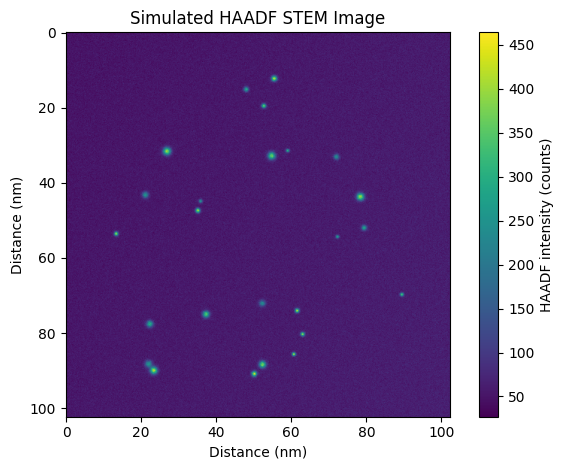

In [9]:
# Visualize using sidpy's plot method
fig = plt.figure()
ds.plot()
plt.show()